In [61]:
import math
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt

In [58]:
file_list = listdir('./daily_data')
file_list_recent = []
for file in file_list:
    if file.find("dec_21_2021") != -1:
        file_list_recent.append(file)
first = True

for file in file_list_recent:
    coin_name = file.split("-")[0]
    if first:
        price_df = pd.read_csv('./daily_data/' + file)
        price_df['coin'] = coin_name
        first = False
    else:
        new_df = pd.read_csv('./daily_data/' + file)
        new_df['coin'] = coin_name
        price_df = price_df.append(new_df)

price_df = price_df.drop('Unnamed: 0', 1)
price_df

/var/folders/gp/0bstcdf92msf4b130ztx6zs00000gn/T/ipykernel_44521/1362203716.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price_df = price_df.drop('Unnamed: 0', 1)


,Date,Open,High,Low,Close,Volume,coin
0,2021-12-20,0.5898,0.6680,0.6483,0.6222,2.018799e+07,GRT
1,2021-12-19,0.6001,0.6677,0.6045,0.6482,1.903754e+07,GRT
2,2021-12-18,0.5810,0.6164,0.5894,0.6049,1.701290e+07,GRT
3,2021-12-17,0.5789,0.6284,0.6138,0.5896,1.869219e+07,GRT
4,2021-12-16,0.6123,0.6684,0.6400,0.6141,1.966700e+07,GRT
...,...,...,...,...,...,...,...
189,2021-06-14,92.3170,103.3730,98.3790,98.5560,4.567910e+04,MLN
190,2021-06-13,91.1510,109.1150,106.4590,97.8780,7.657807e+04,MLN
191,2021-06-12,78.8330,120.3010,85.6330,107.1090,1.208923e+05,MLN
192,2021-06-11,84.4970,108.0620,108.0620,84.5680,5.710109e+04,MLN


Data preprocessing to determine which coins to look at in the analysis. Ideally we want coins which have been around for a long time, and thus we can get enough training data. I will select the top 10 coins which have been around the longest

In [59]:
length_of_listing = price_df[['coin', 'Date']].groupby(by = 'coin').count()
length_of_listing = length_of_listing.nlargest(10, 'Date')

coins_to_trade = length_of_listing.index.to_list()

price_df = price_df[price_df['coin'].isin(coins_to_trade)]
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df_open = price_df[['Date', 'coin', 'Close']]
price_df_open = price_df.drop_duplicates()

price_df_long = price_df_open.pivot(index = 'Date', columns = 'coin', values = 'Close').dropna()

returns = price_df_long.pct_change()
cumul_returns = (1 + returns).cumprod() - 1

/var/folders/gp/0bstcdf92msf4b130ztx6zs00000gn/T/ipykernel_44521/1435192530.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Date'] = pd.to_datetime(price_df['Date'])


Exploring initial metrics of the coins selected

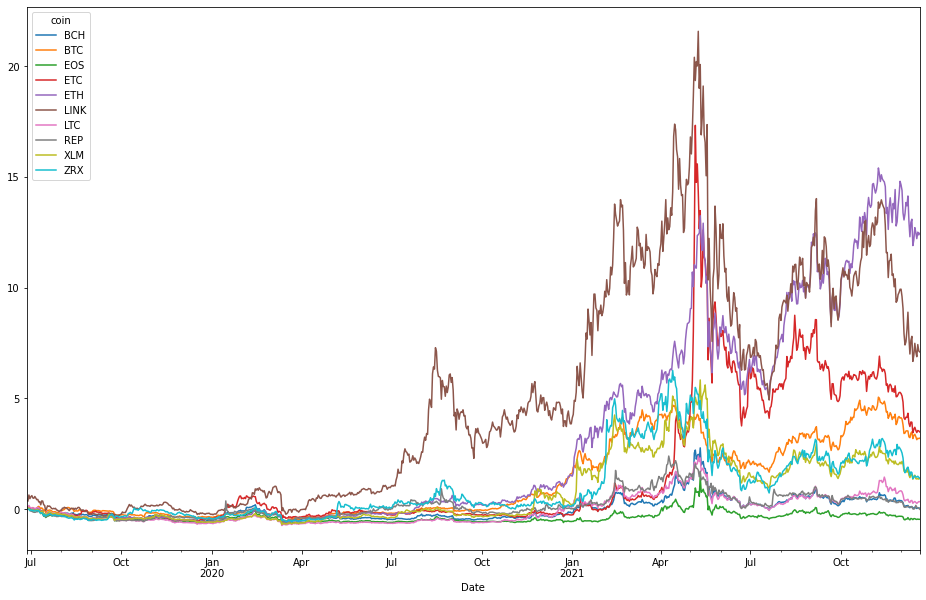

,abs_returns,avg_returns,std_returns,daily_sharpe,yearly_sharpe
coin,,,,,
ETH,12.446553,0.004260,0.051939,0.082022,1.567029
LINK,7.095525,0.004640,0.067968,0.068271,1.304310
BTC,3.205113,0.002431,0.040540,0.059957,1.145471
ETC,3.485714,0.003802,0.067248,0.056539,1.080185
ZRX,1.388282,0.003189,0.067530,0.047229,0.902299
XLM,1.399253,0.002994,0.066079,0.045315,0.865743
LTC,0.337684,0.001887,0.055223,0.034166,0.652746
REP,-0.003619,0.002550,0.077125,0.033068,0.631772
BCH,0.044978,0.001895,0.060704,0.031224,0.596534


In [65]:
plt.rcParams['figure.figsize'] = [16,10]
cumul_returns.plot()
plt.show()

abs_returns = ((price_df_long.iloc[-1] - price_df_long.iloc[0])/price_df_long.iloc[0]).rename("abs_returns")
avg_returns = returns.mean().rename("avg_returns")
std_returns = returns.std().rename("std_returns")

metric_df = pd.concat([abs_returns, avg_returns, std_returns], names=['abs_returns', 'avg_returns', 'std_returns'], axis=1)
metric_df['daily_sharpe'] = metric_df.avg_returns / metric_df.std_returns
# Using 365 to annualized (as compared to 252 trading days in year) because crypto markets are always open
metric_df['yearly_sharpe'] = metric_df.daily_sharpe * math.sqrt(365)
metric_df.sort_values('yearly_sharpe', ascending = False)

In [34]:
cumul_returns.corr()


coin,BCH,BTC,EOS,ETC,ETH,LINK,LTC,REP,XLM,ZRX
coin,,,,,,,,,,
BCH,1.000000,0.833276,0.906056,0.834802,0.837715,0.878824,0.953622,0.844708,0.915044,0.843422
BTC,0.833276,1.000000,0.631249,0.706071,0.916352,0.936310,0.929846,0.861454,0.941789,0.909772
EOS,0.906056,0.631249,1.000000,0.740898,0.664800,0.688863,0.830222,0.716971,0.760136,0.709227
ETC,0.834802,0.706071,0.740898,1.000000,0.893443,0.741151,0.747822,0.625271,0.728799,0.625294
ETH,0.837715,0.916352,0.664800,0.893443,1.000000,0.884542,0.858870,0.748579,0.859986,0.791250
LINK,0.878824,0.936310,0.688863,0.741151,0.884542,1.000000,0.924789,0.919721,0.958697,0.937004
LTC,0.953622,0.929846,0.830222,0.747822,0.858870,0.924789,1.000000,0.881178,0.966625,0.908064
REP,0.844708,0.861454,0.716971,0.625271,0.748579,0.919721,0.881178,1.000000,0.920141,0.950242
XLM,0.915044,0.941789,0.760136,0.728799,0.859986,0.958697,0.966625,0.920141,1.000000,0.949358
